In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from matplotlib import pyplot as plt

/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
base = MobileNetV2(include_top=False)

base.trainable = False
inputs = L.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = L.GlobalAveragePooling2D()(x)
outputs = L.Dense(5)(x)

2021-09-01 18:19:07.495874: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-01 18:19:07.523825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-01 18:19:07.524121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2021-09-01 18:19:07.524138: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-01 18:19:07.526508: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-01 18:19:07.526537: I tensorflow/stream_executor/platfo

9412608/9406464 [==============================] - 1s 0us/step


In [5]:
model = Model(inputs, outputs)
model.compile(Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])
model.save_weights('../checkpoints/mobilenetv2_default.h5')

In [11]:
df = pd.read_csv('../data/train.csv')
df = df[~df['path'].str.endswith('.gif')]

In [12]:
import os
df['path'] = df['path'].apply(lambda x: os.path.join('..', x))

In [13]:
histories = []

for i, (trix, tsix) in enumerate(StratifiedKFold(n_splits=4).split(df, df['class'])):
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=[-60, 60], height_shift_range=[-60, 60],
        horizontal_flip=True, vertical_flip=True,
        zoom_range=[0.5, 1.5]
    ).flow_from_dataframe(df.iloc[trix], x_col='path', target_size=(224, 224), validate_filenames=False)
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_dataframe(df.iloc[tsix], x_col='path', target_size=(224, 224), validate_filenames=False)
    model.load_weights('../checkpoints/mobilenetv2_default.h5')
    h = model.fit(
        train_gen, validation_data=test_gen, epochs=100,
        callbacks=[EarlyStopping(min_delta=0.01, patience=30, restore_best_weights=True)],
        verbose=2
    )
    histories.append(h)

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


2021-09-01 18:21:04.489817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-01 18:21:04.508648: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Epoch 1/100


2021-09-01 18:21:06.643683: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-09-01 18:21:06.811433: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2021-09-01 18:21:06.988291: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-09-01 18:21:06.988321: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-09-01 18:21:06.988847: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-09-01 18:21:06.988887: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-09-01 18:21:06.996550: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

10/10 - 11s - loss: 2.0145 - categorical_accuracy: 0.2007 - val_loss: 1.5412 - val_categorical_accuracy: 0.3196


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2/100
10/10 - 9s - loss: 1.2691 - categorical_accuracy: 0.4706 - val_loss: 0.9166 - val_categorical_accuracy: 0.7423
Epoch 3/100
10/10 - 9s - loss: 0.9274 - categorical_accuracy: 0.6609 - val_loss: 0.6556 - val_categorical_accuracy: 0.8247
Epoch 4/100
10/10 - 9s - loss: 0.7181 - categorical_accuracy: 0.7751 - val_loss: 0.5454 - val_categorical_accuracy: 0.8351
Epoch 5/100
10/10 - 9s - loss: 0.6307 - categorical_accuracy: 0.7855 - val_loss: 0.4989 - val_categorical_accuracy: 0.8660
Epoch 6/100
10/10 - 9s - loss: 0.5305 - categorical_accuracy: 0.8512 - val_loss: 0.4724 - val_categorical_accuracy: 0.8247
Epoch 7/100
10/10 - 9s - loss: 0.4994 - categorical_accuracy: 0.8443 - val_loss: 0.4704 - val_categorical_accuracy: 0.8247
Epoch 8/100
10/10 - 9s - loss: 0.4430 - categorical_accuracy: 0.8547 - val_loss: 0.3968 - val_categorical_accuracy: 0.8763
Epoch 9/100
10/10 - 9s - loss: 0.4940 - categorical_accuracy: 0.8443 - val_loss: 0.3767 - val_categorical_accuracy: 0.8969
Epoch 10/100
10/

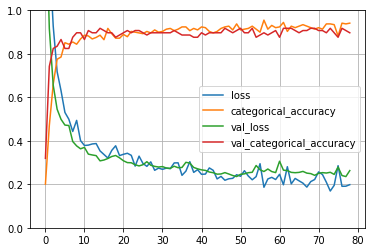

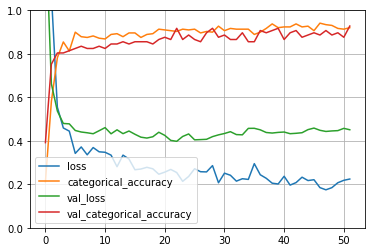

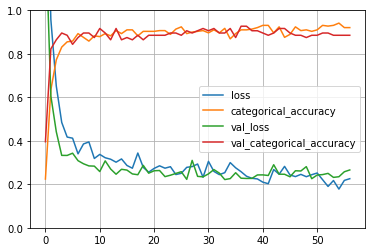

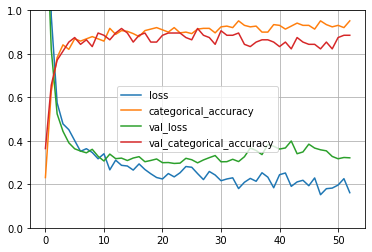

In [14]:
for h in histories:
    plt.figure()
    for k, v in h.history.items():
        plt.plot(v, label=k)
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()

In [16]:
from sklearn.model_selection import train_test_split

xtr, xts = train_test_split(df, stratify=df['class'], test_size=0.2)

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=[-60, 60], height_shift_range=[-60, 60],
    horizontal_flip=True, vertical_flip=True,
    zoom_range=[0.5, 1.5]
).flow_from_dataframe(xtr, x_col='path', target_size=(224, 224), validate_filenames=False)
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_dataframe(xts, x_col='path', target_size=(224, 224), validate_filenames=False)
model.load_weights('../checkpoints/resnet50_default.h5')
h = model.fit(
    train_gen, validation_data=test_gen, epochs=100,
    callbacks=[EarlyStopping(min_delta=0.01, patience=30, restore_best_weights=True)],
    verbose=2
)

Found 308 non-validated image filenames belonging to 5 classes.
Found 78 non-validated image filenames belonging to 5 classes.
Epoch 1/100
10/10 - 10s - loss: 1.9291 - categorical_accuracy: 0.2273 - val_loss: 1.1924 - val_categorical_accuracy: 0.4615


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2/100
10/10 - 10s - loss: 0.8978 - categorical_accuracy: 0.6883 - val_loss: 0.6108 - val_categorical_accuracy: 0.7949
Epoch 3/100
10/10 - 9s - loss: 0.5302 - categorical_accuracy: 0.8214 - val_loss: 0.4268 - val_categorical_accuracy: 0.8462
Epoch 4/100
10/10 - 9s - loss: 0.4510 - categorical_accuracy: 0.8377 - val_loss: 0.3866 - val_categorical_accuracy: 0.8462
Epoch 5/100
10/10 - 9s - loss: 0.4213 - categorical_accuracy: 0.8636 - val_loss: 0.3165 - val_categorical_accuracy: 0.8974
Epoch 6/100
10/10 - 9s - loss: 0.3748 - categorical_accuracy: 0.8734 - val_loss: 0.3374 - val_categorical_accuracy: 0.8974
Epoch 7/100
10/10 - 9s - loss: 0.3801 - categorical_accuracy: 0.8864 - val_loss: 0.3068 - val_categorical_accuracy: 0.8974
Epoch 8/100
10/10 - 9s - loss: 0.3854 - categorical_accuracy: 0.8636 - val_loss: 0.2799 - val_categorical_accuracy: 0.9103
Epoch 9/100
10/10 - 9s - loss: 0.3121 - categorical_accuracy: 0.9026 - val_loss: 0.2684 - val_categorical_accuracy: 0.8974
Epoch 10/100
10

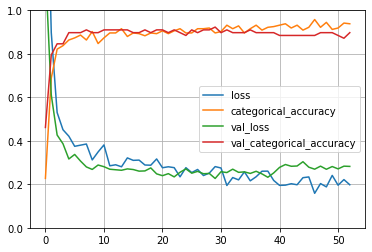

In [17]:
for k, v in h.history.items():
    plt.plot(v, label=k)
plt.ylim(0, 1)
plt.grid()
plt.legend()

In [18]:
model.save('../checkpoints/mobilenetv2-best.h5')

/home/jaidevd/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
